# Keras to Tensorflow Model

In [1]:
import keras
import keras.backend as K
import tensorflow as tf
import numpy as np
np.random.seed(0)
import segmentation_models as sm
import sys
import os
sys.path.append("..")
from seg_net.data import *
from seg_net.fast_scnn import fast_scnn

Using TensorFlow backend.
/home/avantariml/.local/lib/python3.5/site-packages/classification_models/resnext/__init__.py:4: UserWarning: Current ResNext models are deprecated, use keras.applications ResNeXt models
  warnings.warn('Current ResNext models are deprecated, '


## Set Model Architecture

In [2]:
INPUT_SHAPE = (512,512,3) #(528,528,3) (512,512,3) (768,768,3)
NUM_CLASS = 1
BACKBONE = 'mobilenetv2'
MODEL_NAME = 'Unet'
LOSS_METRICS = 'BCE_ACC_IOU'
MODEL_PATH = '../results/Models/Models'
ACTIVATION = 'sigmoid'

# Output protocol buffer model path
model_fname = '{0}_{1}_{2}_{3}_{4}_{5}'.format(BACKBONE,
                                              MODEL_NAME,
                                              LOSS_METRICS,
                                              NUM_CLASS,
                                              ACTIVATION,
                                              INPUT_SHAPE[0])
keras_filename = '{}.hdf5'.format(model_fname)
pb_filename = '{}.pb'.format(model_fname)
pb_op_filename = '{}_op.pb'.format(model_fname)
mlmodel_filename = '{}.mlmodel'.format(model_fname)
mlmodel_fp16_filename = '{}_fp16.mlmodel'.format(model_fname)
mlmodel_Q_filename = '{}_Q.mlmodel'.format(model_fname)
tflite_filename = '{}.tflite'.format(model_fname)
tflite_Q_filename = '{}_Q.tflite'.format(model_fname)

## Build and Load Model

In [4]:
model = sm.Unet(BACKBONE, encoder_weights='imagenet', 
                  classes=NUM_CLASS,
                  activation=ACTIVATION,
                  input_shape = INPUT_SHAPE)

Instructions for updating:
Colocations handled automatically by placer.


/home/avantariml/.local/lib/python3.5/site-packages/segmentation_models/backbones/mobilenetv2.py:273: UserWarning: MobileNet shape is undefined. Weights for input shape(224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


In [3]:
model = fast_scnn(input_shape = INPUT_SHAPE, num_classes = NUM_CLASS, activation = ACTIVATION, dropout_rate = 0.0)

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
model.load_weights(os.path.join(MODEL_PATH,keras_filename))
print("Loading from ",os.path.join(MODEL_PATH,keras_filename))

Loading from  ../results/Models/Models/mobilenetv2_Unet_BCE_ACC_IOU_1_sigmoid_512.hdf5


In [6]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 513, 513, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 256, 256, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 256, 256, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

## save keras model as tf .pb and as CoreML .mlmodel

In [6]:
from tensorflow.python.tools.optimize_for_inference_lib import optimize_for_inference
import coremltools
from seg_net.keras_to_tensorflow import *

In [8]:
input_node_names = [node.op.name for node in model.inputs]
print(input_node_names)

['input_1']


In [9]:
# output_names
output_node_names = [node.op.name for node in model.outputs]
print(output_node_names)

['sigmoid/Sigmoid']


### Freezing the model to .pb

In [11]:
graphDef = freeze_keras(K.get_session(), input_node_names, output_node_names,
                        quantize=False, clear_devices = True)
tf.train.write_graph(graphDef, MODEL_PATH, pb_filename, as_text=False)

Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants


Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants


Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph


Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph


INFO:tensorflow:Froze 560 variables.


INFO:tensorflow:Froze 560 variables.


INFO:tensorflow:Converted 560 variables to const ops.


INFO:tensorflow:Converted 560 variables to const ops.


'../results/Models/Models/mobilenetv2_Unet_BCE_ACC_IOU_1_sigmoid_512.pb'

In [28]:
#sess.run(tf.global_variables_initializer())
graphDef = K.get_session().graph.as_graph_def()
output_node_names_gv = output_node_names + [v.op.name for v in tf.global_variables()]
graphDef = optimize_for_inference(graphDef,
                                   input_node_names,
                                   output_node_names_gv,
                                   tf.float32.as_datatype_enum,
                                   toco_compatible=True)
tf.train.write_graph(graphDef, MODEL_PATH, pb_op_filename, as_text=False)

Instructions for updating:
Use tf.compat.v1.graph_util.remove_training_nodes


Instructions for updating:
Use tf.compat.v1.graph_util.remove_training_nodes


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 3
      }
      dim {
        size: 3
      }
      dim {
        size: 3
      }
      dim {
        size: 32
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 3
      }
      dim {
        size: 3
      }
      dim {
        size: 3
      }
      dim {
        size: 32
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 32
      }
      dim {
        size: 16
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 32
      }
      dim {
        size: 16
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 16
      }
      dim {
        size: 96
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 16
      }
      dim {
        size: 96
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 96
      }
      dim {
        size: 24
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 96
      }
      dim {
        size: 24
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 24
      }
      dim {
        size: 144
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 24
      }
      dim {
        size: 144
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 144
      }
      dim {
        size: 24
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 144
      }
      dim {
        size: 24
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 24
      }
      dim {
        size: 144
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 24
      }
      dim {
        size: 144
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 144
      }
      dim {
        size: 32
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 144
      }
      dim {
        size: 32
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 32
      }
      dim {
        size: 192
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 32
      }
      dim {
        size: 192
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 192
      }
      dim {
        size: 32
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 192
      }
      dim {
        size: 32
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 32
      }
      dim {
        size: 192
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 32
      }
      dim {
        size: 192
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 192
      }
      dim {
        size: 32
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 192
      }
      dim {
        size: 32
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 32
      }
      dim {
        size: 192
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 32
      }
      dim {
        size: 192
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 192
      }
      dim {
        size: 64
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 192
      }
      dim {
        size: 64
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 64
      }
      dim {
        size: 384
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 64
      }
      dim {
        size: 384
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 384
      }
      dim {
        size: 64
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 384
      }
      dim {
        size: 64
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 64
      }
      dim {
        size: 384
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 64
      }
      dim {
        size: 384
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 384
      }
      dim {
        size: 64
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 384
      }
      dim {
        size: 64
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 64
      }
      dim {
        size: 384
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 64
      }
      dim {
        size: 384
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 384
      }
      dim {
        size: 64
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 384
      }
      dim {
        size: 64
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 64
      }
      dim {
        size: 384
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 64
      }
      dim {
        size: 384
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 384
      }
      dim {
        size: 96
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 384
      }
      dim {
        size: 96
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 96
      }
      dim {
        size: 576
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 96
      }
      dim {
        size: 576
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 576
      }
      dim {
        size: 96
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 576
      }
      dim {
        size: 96
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 96
      }
      dim {
        size: 576
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 96
      }
      dim {
        size: 576
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 576
      }
      dim {
        size: 96
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 576
      }
      dim {
        size: 96
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 96
      }
      dim {
        size: 576
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 96
      }
      dim {
        size: 576
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 576
      }
      dim {
        size: 160
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 576
      }
      dim {
        size: 160
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 160
      }
      dim {
        size: 960
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 160
      }
      dim {
        size: 960
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 960
      }
      dim {
        size: 160
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 960
      }
      dim {
        size: 160
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 160
      }
      dim {
        size: 960
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 160
      }
      dim {
        size: 960
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 960
      }
      dim {
        size: 160
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 960
      }
      dim {
        size: 160
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 160
      }
      dim {
        size: 960
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 160
      }
      dim {
        size: 960
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 960
      }
      dim {
        size: 320
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 960
      }
      dim {
        size: 320
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 320
      }
      dim {
        size: 1280
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 320
      }
      dim {
        size: 1280
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 3
      }
      dim {
        size: 3
      }
      dim {
        size: 1856
      }
      dim {
        size: 256
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 3
      }
      dim {
        size: 3
      }
      dim {
        size: 1856
      }
      dim {
        size: 256
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 3
      }
      dim {
        size: 3
      }
      dim {
        size: 256
      }
      dim {
        size: 256
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 3
      }
      dim {
        size: 3
      }
      dim {
        size: 256
      }
      dim {
        size: 256
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 3
      }
      dim {
        size: 3
      }
      dim {
        size: 448
      }
      dim {
        size: 128
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 3
      }
      dim {
        size: 3
      }
      dim {
        size: 448
      }
      dim {
        size: 128
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 3
      }
      dim {
        size: 3
      }
      dim {
        size: 128
      }
      dim {
        size: 128
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 3
      }
      dim {
        size: 3
      }
      dim {
        size: 128
      }
      dim {
        size: 128
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 3
      }
      dim {
        size: 3
      }
      dim {
        size: 272
      }
      dim {
        size: 64
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 3
      }
      dim {
        size: 3
      }
      dim {
        size: 272
      }
      dim {
        size: 64
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 3
      }
      dim {
        size: 3
      }
      dim {
        size: 64
      }
      dim {
        size: 64
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 3
      }
      dim {
        size: 3
      }
      dim {
        size: 64
      }
      dim {
        size: 64
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 3
      }
      dim {
        size: 3
      }
      dim {
        size: 160
      }
      dim {
        size: 32
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 3
      }
      dim {
        size: 3
      }
      dim {
        size: 160
      }
      dim {
        size: 32
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 3
      }
      dim {
        size: 3
      }
      dim {
        size: 32
      }
      dim {
        size: 32
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 3
      }
      dim {
        size: 3
      }
      dim {
        size: 32
      }
      dim {
        size: 32
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 3
      }
      dim {
        size: 3
      }
      dim {
        size: 32
      }
      dim {
        size: 16
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 3
      }
      dim {
        size: 3
      }
      dim {
        size: 32
      }
      dim {
        size: 16
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 3
      }
      dim {
        size: 3
      }
      dim {
        size: 16
      }
      dim {
        size: 16
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 3
      }
      dim {
        size: 3
      }
      dim {
        size: 16
      }
      dim {
        size: 16
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


'../results/Models/Models/mobilenetv2_Unet_BCE_ACC_IOU_1_sigmoid_512_op.pb'

### keras to .tflite

In [10]:
# Converting a tf.keras model.
converter = tf.lite.TFLiteConverter.from_session(K.get_session(), model.inputs, model.outputs)
tflite_model = converter.convert()
with open(os.path.join(MODEL_PATH,tflite_filename), "wb") as f:
    f.write(tflite_model)

Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants
Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph
INFO:tensorflow:Froze 312 variables.
INFO:tensorflow:Converted 312 variables to const ops.


In [17]:
# Converting a tf.keras model.
converter_Q = tf.lite.TFLiteConverter.from_session(K.get_session(), model.inputs, model.outputs)
converter_Q.post_training_quantize=True
tflite_Q_model = converter_Q.convert()
with open(os.path.join(MODEL_PATH,tflite_Q_filename), "wb") as f:
    f.write(tflite_Q_model)

INFO:tensorflow:Froze 312 variables.
INFO:tensorflow:Converted 312 variables to const ops.


### keras to .mlmodel

In [13]:
def convert_lambda(layer):
    
    import keras.backend as K
    # Only convert this Lambda layer if it is for our tf image resize function.
    if layer.function == K.tf.image.resize_images:

        from coremltools.proto import NeuralNetwork_pb2

        params = NeuralNetwork_pb2.CustomLayerParams()

        # The name of the Swift or Obj-C class that implements this layer.
        params.className = "Resize"

        # The desciption is shown in Xcode's mlmodel viewer.
        params.description = "A resize function"

        return params
    else:
        return None
    
coreml_model = coremltools.converters.keras.convert(model,
                                                    input_names=input_node_names,
                                                    image_input_names=input_node_names,
                                                    output_names=output_node_names,
                                                    image_scale=1/255.0,
                                                    add_custom_layers=True,
                                                    custom_conversion_functions={ "Lambda": convert_lambda }
                                                   )

Output name length mismatch
0 : input_1, <keras.engine.input_layer.InputLayer object at 0x7fbb88352d68>
1 : Conv1_pad, <keras.layers.convolutional.ZeroPadding2D object at 0x7fbb8835abe0>
2 : Conv1, <keras.layers.convolutional.Conv2D object at 0x7fbb8835aba8>
3 : bn_Conv1, <keras.layers.normalization.BatchNormalization object at 0x7fbade824048>
4 : Conv1_relu, <keras.layers.advanced_activations.ReLU object at 0x7fbade824b00>
5 : expanded_conv_depthwise, <keras.layers.convolutional.DepthwiseConv2D object at 0x7fbade824f98>
6 : expanded_conv_depthwise_BN, <keras.layers.normalization.BatchNormalization object at 0x7fbade8245c0>
7 : expanded_conv_depthwise_relu, <keras.layers.advanced_activations.ReLU object at 0x7fbadc24b748>
8 : expanded_conv_project, <keras.layers.convolutional.Conv2D object at 0x7fbadc1e0978>
9 : expanded_conv_project_BN, <keras.layers.normalization.BatchNormalization object at 0x7fbadc1adfd0>
10 : block_1_expand, <keras.layers.convolutional.Conv2D object at 0x7fbadc14c

95 : block_10_depthwise_BN, <keras.layers.normalization.BatchNormalization object at 0x7fba78494ef0>
96 : block_10_depthwise_relu, <keras.layers.advanced_activations.ReLU object at 0x7fba783ebf60>
97 : block_10_project, <keras.layers.convolutional.Conv2D object at 0x7fba7834bba8>
98 : block_10_project_BN, <keras.layers.normalization.BatchNormalization object at 0x7fba78306898>
99 : block_11_expand, <keras.layers.convolutional.Conv2D object at 0x7fba782eeb38>
100 : block_11_expand_BN, <keras.layers.normalization.BatchNormalization object at 0x7fba7824ccf8>
101 : block_11_expand_relu, <keras.layers.advanced_activations.ReLU object at 0x7fba781eec50>
102 : block_11_depthwise, <keras.layers.convolutional.DepthwiseConv2D object at 0x7fba78194f60>
103 : block_11_depthwise_BN, <keras.layers.normalization.BatchNormalization object at 0x7fba781055f8>
104 : block_11_depthwise_relu, <keras.layers.advanced_activations.ReLU object at 0x7fba780ed8d0>
105 : block_11_project, <keras.layers.convolution

189 : decoder_stage4_bn1, <keras.layers.normalization.BatchNormalization object at 0x7fba59ed0550>
190 : decoder_stage4_relu1, <keras.layers.core.Activation object at 0x7fba59ed0e80>
191 : decoder_stage4_conv2, <keras.layers.convolutional.Conv2D object at 0x7fba59ed0eb8>
192 : decoder_stage4_bn2, <keras.layers.normalization.BatchNormalization object at 0x7fba59e42470>
193 : decoder_stage4_relu2, <keras.layers.core.Activation object at 0x7fba59e31fd0>
194 : final_conv, <keras.layers.convolutional.Conv2D object at 0x7fba59da2d68>
195 : sigmoid, <keras.layers.core.Activation object at 0x7fba59d73c18>


In [14]:
spec = coreml_model.get_spec()
print(spec.description)

input {
  name: "input_1"
  type {
    imageType {
      width: 512
      height: 512
      colorSpace: RGB
    }
  }
}
output {
  name: "sigmoid/Sigmoid"
  type {
    multiArrayType {
      shape: 1
      shape: 512
      shape: 512
      dataType: DOUBLE
    }
  }
}



In [15]:
coreml_model.save(os.path.join(MODEL_PATH, mlmodel_filename))

In [16]:
model_spec = coremltools.utils.load_spec(os.path.join(MODEL_PATH, mlmodel_filename))
model_fp16_spec = coremltools.utils.convert_neural_network_spec_weights_to_fp16(model_spec)
coremltools.utils.save_spec(model_fp16_spec, os.path.join(MODEL_PATH, mlmodel_fp16_filename))

In [17]:
quantized_coreml_spec = coremltools.models.neural_network.quantization_utils.quantize_weights(coreml_model,8)
coremltools.utils.save_spec(quantized_coreml_spec, os.path.join(MODEL_PATH, mlmodel_Q_filename))

Quantizing using linear quantization
Optimizing Neural Network before Quantization:
Fused Conv1->bn_Conv1
Fused expanded_conv_depthwise->expanded_conv_depthwise_BN
Fused expanded_conv_project->expanded_conv_project_BN
Fused block_1_expand->block_1_expand_BN
Fused block_1_depthwise->block_1_depthwise_BN
Fused block_1_project->block_1_project_BN
Fused block_2_expand->block_2_expand_BN
Fused block_2_depthwise->block_2_depthwise_BN
Fused block_2_project->block_2_project_BN
Fused block_3_expand->block_3_expand_BN
Fused block_3_depthwise->block_3_depthwise_BN
Fused block_3_project->block_3_project_BN
Fused block_4_expand->block_4_expand_BN
Fused block_4_depthwise->block_4_depthwise_BN
Fused block_4_project->block_4_project_BN
Fused block_5_expand->block_5_expand_BN
Fused block_5_depthwise->block_5_depthwise_BN
Fused block_5_project->block_5_project_BN
Fused block_6_expand->block_6_expand_BN
Fused block_6_depthwise->block_6_depthwise_BN
Fused block_6_project->block_6_project_BN
Fused block_7_

## load & inference the model

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import random
import skimage
import glob
import os
import cv2

In [5]:
# Load Test Images
test_path = "../data/raw/test"
fnames = sorted(glob.glob(os.path.join(test_path,"*.jpg")))
images = []
outs = []
for f in fnames:
    img = skimage.io.imread(f)
    images.append(img)

In [35]:
# load model from pb file
with tf.gfile.GFile(os.path.join(MODEL_PATH,pb_op_filename),'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    sess.graph.as_default()
    g_in = tf.import_graph_def(graph_def)
print("Loading from ",os.path.join(MODEL_PATH,pb_op_filename))

Loading from  ../results/Models/Models/mobilenetv2_Unet_BCE_ACC_IOU_1_sigmoid_512_op.pb


CPU times: user 974 ms, sys: 79.3 ms, total: 1.05 s
Wall time: 955 ms


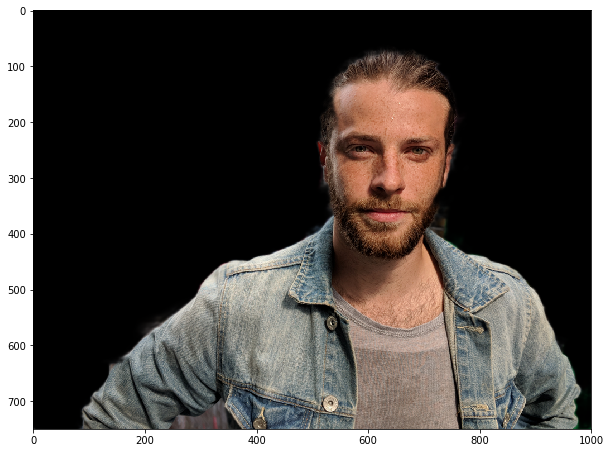

In [39]:
%%time
# Choose a random image and preprocess for inference.
i = random.choice(range(0,len(images)))
img  = images[i]
img_ = np.expand_dims(cv2.resize(img,INPUT_SHAPE[:2]),axis=0)
img_ = preprocess_input(img_, imgNorm="divide")
# inference by the model (op name must comes with :0 to specify the index of its output)
sess = tf.Session()
tensor_output = sess.graph.get_tensor_by_name('import/sigmoid/Sigmoid:0')
tensor_input = sess.graph.get_tensor_by_name('import/input_1:0')
output = sess.run(tensor_output, {tensor_input: img_})
sess.close()
# Resize and Apply Mask on input image.
mask = skimage.transform.resize(np.squeeze(output),img.shape[:2],preserve_range=True)
im = cv2.multiply(np.repeat(np.expand_dims(mask,axis=-1),3,axis=2).astype(float), img.astype(float))/255
plt.rcParams['figure.figsize'] = [10,10]
plt.imshow(im)

### Testing TFLite model using Python API

In [27]:
# Load TFLite model and allocate tensors.
#interpreter = tf.lite.Interpreter(model_path=os.path.join(MODEL_PATH,tflite_filename))
interpreter = tf.lite.Interpreter(model_path=os.path.join(MODEL_PATH,tflite_Q_filename))
#interpreter = tf.lite.Interpreter(model_path="/media/new_hdd2/seg_net/results/Models/Models/sample_tf.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_details[0]['shape']

array([  1, 512, 512,   3], dtype=int32)

CPU times: user 6.49 s, sys: 87.1 ms, total: 6.58 s
Wall time: 6.25 s


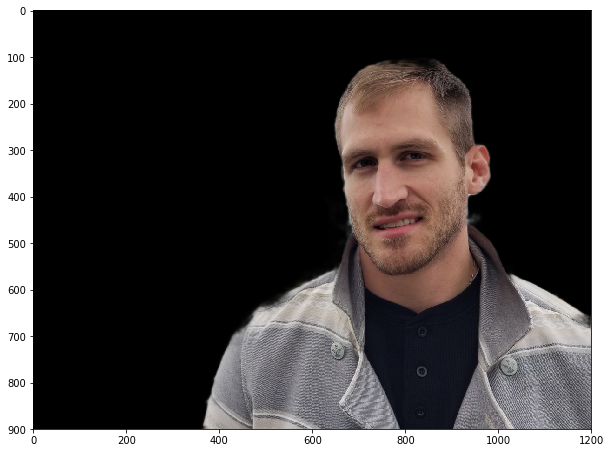

In [32]:
%%time
# Choose a random image and preprocess for inference.
i = random.choice(range(0,len(images)))
img  = images[i]#skimage.io.imread("/home/avantariml/Downloads/IMG_3309.jpg")
img_ = np.expand_dims(cv2.resize(img,INPUT_SHAPE[:2]),axis=0)
#img_ = np.expand_dims(cv2.resize(img,(257, 257)),axis=0)
img_ = preprocess_input(img_, imgNorm="divide")
interpreter.set_tensor(input_details[0]['index'], img_)
interpreter.invoke()
output = interpreter.get_tensor(output_details[0]['index'])
# Resize and Apply Mask on input image.
mask = skimage.transform.resize(np.squeeze(output),img.shape[:2],preserve_range=True)
im = cv2.multiply(np.repeat(np.expand_dims(mask,axis=-1),3,axis=2).astype(float), img.astype(float))/255
plt.rcParams['figure.figsize'] = [10,10]
plt.imshow(im)#(np.squeeze(output))